## Gig Economy Project

By: Janet Taylor & Evan Kessler

Workers in the gig economy (i.e., Uber, GrubHub, TaskRabbit, etc.) depend on the reviews they get to continue working on the platform. Workers on those platforms are often affected by receiving negative reviews that describe elements that were not under their control. The project explores how the analysis of online reviews can detect when unfair reviews are left to workers and identify the type of unfair review that was left.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from textblob import TextBlob
from matplotlib import pyplot as plt
import nltk

In [2]:
uber = pd.read_csv("uber_cleaned.csv")
lyft = pd.read_csv("lyft_cleaned.csv")
uber.head()

,# Reviews By User,User URL,State,Username,Country,Date Review Given,Invited,Review URL,Review Title,Review Body,Date of Experience,Rating,Company,Unfair
0,3,https://www.trustpilot.com/users/602209d7fe424...,KA,KATHLEEN,US,5 hours ago,True,https://www.trustpilot.com/reviews/63f228859b6...,Ellie was exceptional,"all your driver's we very good, knowledgeable ...",2023-02-16,5,Uber,False
1,1,https://www.trustpilot.com/users/63f17dca2c3e9...,TL,Thomas Littleton,US,17 hours ago,True,https://www.trustpilot.com/reviews/63f17dcb9b6...,Disappointed,driver canceled the ride because he couldn’t f...,2023-02-16,3,Uber,False
2,1,https://www.trustpilot.com/users/63f1a4db8f663...,NaN,kumar kanakapura,IN,14 hours ago,False,https://www.trustpilot.com/reviews/63f1a4ef6f3...,Nasty behavior of Uber auto driver,uber driver complained he does not know the ro...,2023-02-17,1,Uber,False
3,2,https://www.trustpilot.com/users/5d1540199a289...,TL,tlsg1951,US,2 days ago,True,https://www.trustpilot.com/reviews/63f02b579b6...,drivers were great but,"my drivers were great, on time, comfortable pe...",2023-02-14,4,Uber,True
4,2,https://www.trustpilot.com/users/5e35c6d6ddcef...,TE,Terry,US,2 days ago,True,https://www.trustpilot.com/reviews/63f013789b6...,My debit card was charged twice for a…,my debit card was charged twice for a pre sche...,2023-02-15,1,Uber,False


In [3]:
sentiment_scores = []
for review in uber['Review Body']:
    blob = TextBlob(review)
    sentiment_scores.append(blob.sentiment.polarity)

# Add the sentiment polarity scores as a new column in the dataframe
uber['Sentiment_Polarity'] = sentiment_scores

In [4]:
labeled = uber[uber.Unfair.notnull()][["# Reviews By User", "Invited", "Sentiment_Polarity", "Review Body", "Rating",  "Unfair"]]
labeled = labeled.astype({'Invited': 'int32', "Unfair": 'int32'})
unpopped = labeled.copy()
labels = labeled.pop("Unfair")

labeled["Review Body"] = [str(TextBlob(review).correct()) for review in labeled["Review Body"]]

X_train, X_test, y_train, y_test = train_test_split(labeled, labels, test_size=0.33, random_state=938)

In [5]:
from textblob.classifiers import NaiveBayesClassifier

cl_train = []
for x, y in zip(X_train["Review Body"], y_train):
    cl_train.append((x, y))


cl = NaiveBayesClassifier(cl_train, format='json')

predictions = [cl.classify(item) for item in X_test["Review Body"]]
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(len(list(filter(lambda x: x, y_test))))

labeled['BayesResult'] = [cl.classify(x) for x in labeled["Review Body"]]

X_train, X_test, y_train, y_test = train_test_split(labeled, labels, test_size=0.33, random_state=938)



[[133   9]
 [ 17   6]]
0.8424242424242424
0.2608695652173913
23


In [6]:
lr = LogisticRegression()
lr.fit(X_train.loc[:, ~X_train.columns.isin(["Review Body", "BayesResult"])], y_train)


predictions = lr.predict(X_test.loc[:, ~X_test.columns.isin(["Review Body", "BayesResult"])])
predictions
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(len(list(filter(lambda x: x, y_test))), len(list(filter(lambda x: x, predictions))))

[[129  13]
 [ 10  13]]
0.8606060606060606
0.5652173913043478
23 26


In [7]:
lr = LogisticRegression()
lr.fit(X_train.loc[:, ~X_train.columns.isin(["Review Body"])], y_train)


predictions = lr.predict(X_test.loc[:, ~X_test.columns.isin(["Review Body"])])
predictions
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(len(list(filter(lambda x: x, y_test))), len(list(filter(lambda x: x, predictions))))

[[134   8]
 [ 15   8]]
0.8606060606060606
0.34782608695652173
23 16


SVC kernel is poly
WITH SENTIMENT ANALYSIS


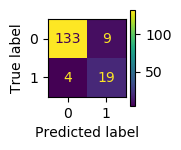

Accuracy: 0.9212121212121213
Recall: 0.8260869565217391
Precision: 0.6785714285714286
F1: 0.7450980392156864

WITHOUT SENTIMENT ANALYSIS


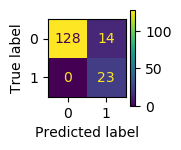

Accuracy: 0.9151515151515152
Recall: 1.0
Precision: 0.6216216216216216
F1: 0.7666666666666667


In [8]:
from sklearn.svm import SVC

kernel = 'poly'
lr = SVC(kernel=kernel, degree=8, class_weight='balanced', coef0=2.4, shrinking=False)
print("SVC kernel is " + kernel)


def perform_SVC(exclude):
    exclude = ~X_train.columns.isin(exclude)    
    lr.fit(X_train.loc[:, exclude], y_train)
    predictions = lr.predict(X_test.loc[:, exclude])
    predictions
    _, ax = plt.subplots(figsize=(1.25, 1.25))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
    disp.plot(ax=ax)
    plt.show()
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Recall:", recall_score(y_test, predictions))
    print("Precision:", precision_score(y_test, predictions))
    print("F1:", f1_score(y_test, predictions))
    

print("WITH SENTIMENT ANALYSIS")
perform_SVC(["Review Body"])

print("\nWITHOUT SENTIMENT ANALYSIS")
perform_SVC(["Review Body", "Sentiment_Polarity", "BayesResult"])

In [9]:
import matplotlib.pyplot as plt

print(labeled["Sentiment_Polarity"].describe())
print(unpopped[unpopped.Unfair == 1]["Sentiment_Polarity"].describe())
print(unpopped[unpopped.Unfair == 0]["Sentiment_Polarity"].describe())

count    500.000000
mean       0.332554
std        0.300322
min       -1.000000
25%        0.178750
50%        0.386617
75%        0.525937
max        1.000000
Name: Sentiment_Polarity, dtype: float64
count    84.000000
mean      0.063143
std       0.248464
min      -0.937500
25%      -0.011111
50%       0.083333
75%       0.211786
max       0.700000
Name: Sentiment_Polarity, dtype: float64
count    416.000000
mean       0.386955
std        0.280080
min       -1.000000
25%        0.274306
50%        0.437500
75%        0.550000
max        1.000000
Name: Sentiment_Polarity, dtype: float64
